# <i>COMXXX - Computers and Music</i> <br /> <br />  <b>Dynamic range compressor</b> 
<div align="right"><a href="link">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>
<br />

In [1]:
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

from numpy.fft import fft, ifft, hfft
from scipy.signal import lfilter
from scipy.io import wavfile
from IPython.display import Audio
from scipy import signal
import import_ipynb
from Helpers import *

figsize=(10,5)
matplotlib.rcParams.update({'font.size': 16})

importing Jupyter notebook from Helpers.ipynb


In [2]:
fs=44100

In this notebook, we will implement a **Dynamic range compressor**, often abreviated simply compressor. It is an audio production effect and device, that, as its name suggests, reduces the dynamic range of an audio signal. This is useful to bring different levels of sound to a more uniform range of volume. For instance, it is useful when recording voice, given that the singer may move while singing and hence the microphone may capture the voice more or less loud during the recoring. Using a compressor can allow to bring the voice to a constant level on the whole recording.

<img src="https://images.squarespace-cdn.com/content/v1/5c769d6ff4755a07a9f098ec/1552514416823-OVZDHK9EK0VJOUWMM17M/ke17ZwdGBToddI8pDm48kDMwLx6TsOhVXlflIA2kqbB7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UZInJzBGMcFust3g7EuYdlJdIj_SSyU5DGRuDRS2XdNzv3WwuoKep38JmcVMpLq5Fw/Sebatron_SMAC_2-Channel_Compressor.jpg" alt="Drawing" style="width: 35%;"/>

To implement a very basic compressor, one could simply use a map table to change the values of amplitudes greater or lower than a threshold, however this would lead to audibly distorting the signal. A compressor is hence built using several components 

## 1. The components of a compressor

### 1.1. The gain computer

The gain computer is in charge of applying the static compression gain to amplitudes abobe the threshold, and to leave the amplitudes below unchanged. It does not deal with time and treats each sample individually. The gain computer takes a signal $x_G$ (whose values are in dB) and decomposes it in samples. It takes 3 more arguments:
- The threshold value $T$ in dB, determining the limit from which the compression should be active
- The knee width $W$ describing the width of the area centered on the threshold in which the compression curve is rounded (a value of $W=0$ yields a hard corder between the zones where the compression is on and off)
- The ratio $R$ describing how flat the active compression curve should be: the higher the ratio, the flatter the curve will be in the active area.

For each sample $x_G[n]$, the gain computer hence distinguishes 3 cases:

$$\forall n, y_G [n] = 
\begin{cases}
    x_G[n], &\text{if } 2(x_G[n]-T)< -W \text{ (below the soft-knee: compression is off)} \\
    x_G[n] + (1/R-1) (x_G[n] - T + W/2)^2 / (2W) , &\text{if } 2 |x_G[n] - T| \leq W \text{ (inside the soft knee)}\\
    T + (x_G[n] - T)/R, &\text{if } 2(x_G[n] - T) > W \text{ (above the soft knee: compression is on)}.
\end{cases}
$$

In [3]:
def gain_computer(x_G, T, W, R):
    """
    Static compression gain computer applied to input signal x_G[n] in dB.
    x_G: input signal with values in dB
    T: threshold value in dB
    W: width of the transition knee between where the compression is on and off
    R: ratio of the compression for the region where the compression in on
    output: the statically compressed signal, also in dB
    """
    y_G = np.zeros(x_G.size) # init y_G
    y_G = np.where(2 * (x_G - T) < -W,       x_G, y_G) # Compression off level range
    y_G = np.where(2 * np.abs(x_G - T) <= W, x_G + (1/R - 1)*(x_G - T + W/2)**2 / (2*W), y_G) # Soft-knee range
    y_G = np.where(2 * (x_G - T) > W,        T + (x_G - T)/R,  y_G) # Compression on range
    
    return y_G

We can now test it with different values of $T$, $W$ and $R$. Using the sliders, you can try out different values.

In [4]:
@widgets.interact(T=(-100, 0, 10), W=(5, 30, 5), R=(1, 20, 1))
def update(T = -30, W=10, R=4):
    
    fig, ax = plt.subplots(figsize=figsize)
    compression_curve = gain_computer(np.linspace(-100, 0, 200000), T, W, R)
    ax.plot(np.linspace(-100, 0, 200000), compression_curve, label="Compression curve")
    ax.plot(np.linspace(-100, 0, 200000), np.linspace(-100, 0, 200000), alpha=.3, linestyle="dashed", color="gray")
    ax.grid(True)
    ax.set_xlim([-100, 0])
    ax.set_ylim([-100, 0])
    ax.axvline(T, label="Threshold", color="red")
    ax.axvspan(T-W/2, T+W/2, alpha=0.3, color='orange', label="Soft-knee")
    plt.xlabel("Input [dB]")
    plt.ylabel("Output [dB]")
    plt.title("Static compression curve")
    ax.legend(loc="best")
    plt.show()

interactive(children=(IntSlider(value=-30, description='T', max=0, min=-100, step=10), IntSlider(value=10, des…

### 1.2. The peak detector

Using a static compression has some drawacks. The main one is that the sound gets weak as all the transients are systemmatically getting crushed, removing an important part of the sound. Since the attack of a sound is determining for the perception we have of it, it is necessary to keep the transients while compressing the sustain of the sounds. This is done by adding an additional control to the compressor, the **attack time** $at$. The attack time is the time the compressor will take to start having an effect, each time that the input sounds enter the "on" region (above the threshold). This attack time will allow to let the transient unchanged through the compressor.

Complementarily, a control called **release time** $rt$ sets how fast the compressor goes back to the inactive mode as soon as the input signal gets below the threshold. The attack time is generally set to be around 10 to 100ms while the reslease time is often set between 100 and 1000ms. 

Mathematically, this translates to

$$
    \forall n, y_L[n] = 
    \begin{cases}
        \alpha_A y_L[n-1] + (1-\alpha_A) x_L[n], &\text{if } x_L[n] > y_L[n-1] \\
        \alpha_R y_L[n-1] + (1-\alpha_R) x_L[n], &\text{if } x_L[n] \leq y_L[n-1]
    \end{cases}
$$
where
$$ 
\alpha_A = \exp{(-1 / at \cdot f_s)} \\
\alpha_R = \exp{(-1 / rt \cdot f_s)} .
$$

In [27]:
def peak_detector(x_L, at, rt):
    """
    Peak detector computing y_L in dB based on x_L in dB.
    x_L: input signal
    at: the attack time in seconds
    rt: the release time in seconds
    return: smoothed out envelope with attack and release transitions
    """
    attack, release = np.exp(-1/(at*fs)), np.exp(-1/(rt*fs)) # Convert attack/release times into coefs in (0,1)
    y_L = np.copy(x_L) # init Y_L
    
    for n in range(1, x_L.size):
        if x_L[n] > y_L[n-1] :
            y_L[n] = attack * y_L[n-1] + (1-attack) * x_L[n]
        else:
            y_L[n] = release * y_L[n-1] + (1-release) * x_L[n]

    return y_L

We can now observe the influence of different attack and release times on a simple square pulse. The square pulse is here used as an example of **envelope** for a signal (not the signal itself!). It is interesting to see that if the attack time gets long, the signal does not have enough time to reach the value of the input signal before the input signal changes value again. The release curve has hence to be computed from where the signal was, to avoid jumps.

In [6]:
square = np.zeros(3*fs)
square[int(.5*fs):int(1.5*fs)] = 1

@widgets.interact(at=(0.01, 1, .05), rt=(0.01, 1, .05))
def update(at = .1, rt=.5):
    
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(square, label="Dry signal")
    ax.plot(peak_detector(square, at, rt) , label="Signal with envelope")
    plt.title("Attack-release envelope")
    plt.xlabel("Time [samples]")
    plt.ylabel("Envelope amplitude")
    plt.legend(loc="best")
    plt.show()

interactive(children=(FloatSlider(value=0.1, description='at', max=1.0, min=0.01, step=0.05), FloatSlider(valu…

## 2. The compressor (itself)

Let us now move to implementing the compressor itself. A compressor is often implemented in the following way: first the input signal $x$ is copied to a parallel processing circuit called the **sidechain**, where all the computation is done about the final gain of the signal over time. Then, the sidechain is multiplied back with the original signal before being outputed. Everything to be implemented hence happens inside the sidechain.

As you have seen above, all the computations are done in the dB domain, in order to match the human perception of the sound. The first step of the sidechain processing is hence to convert the copy of the signal $x$ to dBs. We call this dB signal $x_G$. Similarly, the last step before multiplying the sidechain back with the signal is to convert it back to the linear domain.

$x_G$ is then sent to the gain computer where it recieves a static compression, that does not depend on time. The statically compressed signal is called $y_G$. We then compute the difference between $x_G$ and $y_G$ in order to obtain the values in dB of the amplitudes that must be reduced only, that is the amplitudes belonging to the region above the threshold, and we call it $x_L$. 

$x_L$ is subsequencly sent to the peak detector to avoid compressing the transients. The output is called $y_L$ and contains the amplitudes above the threshold, but with the attack-release envelope this time active. This value is inverted as it corresponds to the quantity of amplitude that has to be removed from the signal, i.e. the amount of volume to be reduced. 

One last parameter, called the makeup $M$, is simply an additional constant gain to be added to the signal to compensate for the lost amplitude after compression. We add $M$ to $-y_L$, before converting this back to linear. Finally, this is multiplied to the original signal $x$.

<img src="https://i.imgur.com/PMLzEwG.png" style="width: 70%;" />

In [24]:
def compressor(x, T=-30, W=10, R=4, M=0, at=.1, rt=.5):
    """
    Dynamic range compressor
    """
    epsilon = .0000001 # Avoid log(0) in next line
    x_G = 20 * np.log10(np.abs(x) + epsilon) # Conversion to dB domain
    y_G = gain_computer(x_G, T, W, R) # Static compression gain computer
    
    x_L =  x_G - y_G # Get only the amplitudes to be reduced
    y_L = peak_detector(x_L, at, rt) # Apply attack and release envelope
    
    x_M = M - y_L # Add makeup gain and invert the signal since it must be taken out of the input
    sidechain = np.power(10, x_M / 20) # Conversion back to linear domain
    
    return x * sidechain # Apply sidechain to input

2.663309729610546


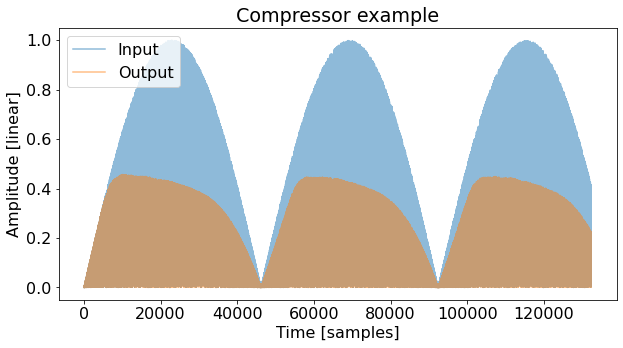

In [8]:
test_input = np.abs(np.sin(3*np.linspace(0, 3, 3*fs))) * np.random.random(3*fs)
test_comp = compressor(test_input, T=-10, W=5, R=8, M=0, at=.01, rt=.5)

plt.figure(figsize=figsize)
plt.plot(test_input, alpha=.5, label="Input")
plt.plot(test_comp, alpha=.5, label="Output")
plt.xlabel("Time [samples]")
plt.ylabel("Amplitude [linear]")
plt.title("Compressor example")
plt.legend(loc="best")
plt.show()

## 3. Testing it with a voice sample

We can finally test our algorithm with an sample of speech. The original speech features a large disparity between louder and quiter samples. 

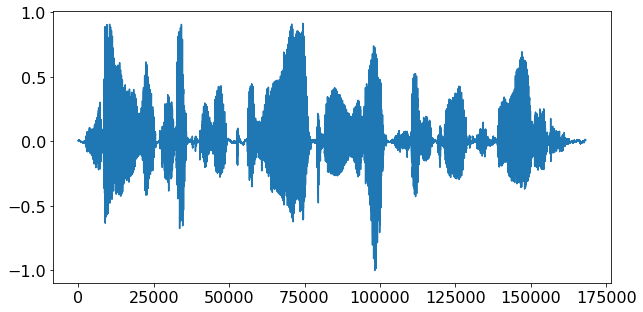

In [9]:
speech = open_audio('samples/speech.wav')
Audio("samples/speech.wav", autoplay=False)

After compressing the speech, and increasing the makeup gain, the louder samples are reduces, while the quiter samples are increased, bringing everything closer to the threshold.

In [32]:
@widgets.interact(T=(-100, 0, 10), M=(0, 60, 10), at=(.00001, .001, .00001), rt=(.001, 1, .001))
def update(T = -40, M=30, at=.0001, rt=.1):

    speech_comp = compressor(speech, T, 10, 20, M, at, rt)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(np.abs(speech), alpha=.5, label="Original voice")
    ax.plot(np.abs(speech_comp), alpha=.5, label="Compressed voice")
    ax.axhline(np.power(10, (M+T) / 20), label="Threshold+makeup", color="red")
    ax.set_ylim([-0.05, 1.05])
    plt.xlabel("Time [samples]")
    plt.ylabel("Abs amplitude [linear]")
    plt.legend(loc="best")
    plt.show()

interactive(children=(IntSlider(value=-40, description='T', max=0, min=-100, step=10), IntSlider(value=30, des…

In [33]:
write_audio(compressor(speech, -40, 10, 20, 30, .0001, .1), 'samples/speech_comp.wav')